In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0,'..')
import module as mod

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [5]:
all_windows = ['2min', '5min', '10min', '30min', '1h', '2h', '3h', '5h', '12h']
house2_power_blk1, features_cols = mod.generate_features(house2_power_blk1, window=all_windows)

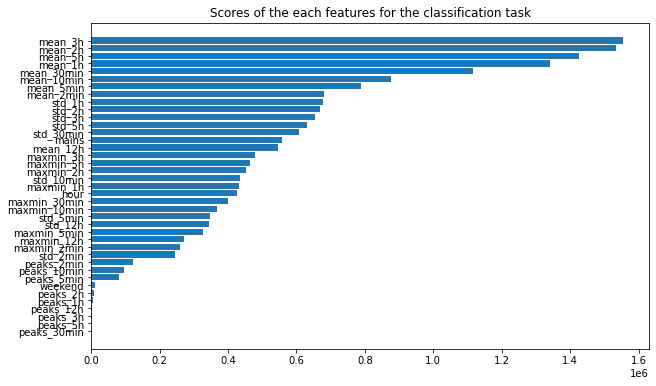

In [7]:
# ideally this would be done after a split test / train
fs = SelectKBest()
all_features = ['mains', 'hour'] + features_cols
fs.fit_transform(house2_power_blk1.loc[:, all_features].values, house2_power_blk1.loc[:, 'activity'].values)

sorted_scores_idx = np.argsort(fs.scores_)
#features = np.array([str(i) for i in sorted_scores_idx])
fig = plt.figure(figsize=(10, 6))
plt.barh(y=np.array(all_features)[sorted_scores_idx], width=fs.scores_[sorted_scores_idx]);
plt.title('Scores of the each features for the classification task');

Sur ce jeu de données 2 heures et 10 minutes semblent être les deux fenêtres optimales.

In [9]:
best_windows = ['1h', '10min']
features_col = ['mains', 'hour', 'weekend'] + [func+window for window in best_windows for func in ['std_', 'mean_', 'maxmin_', 'peaks_']]

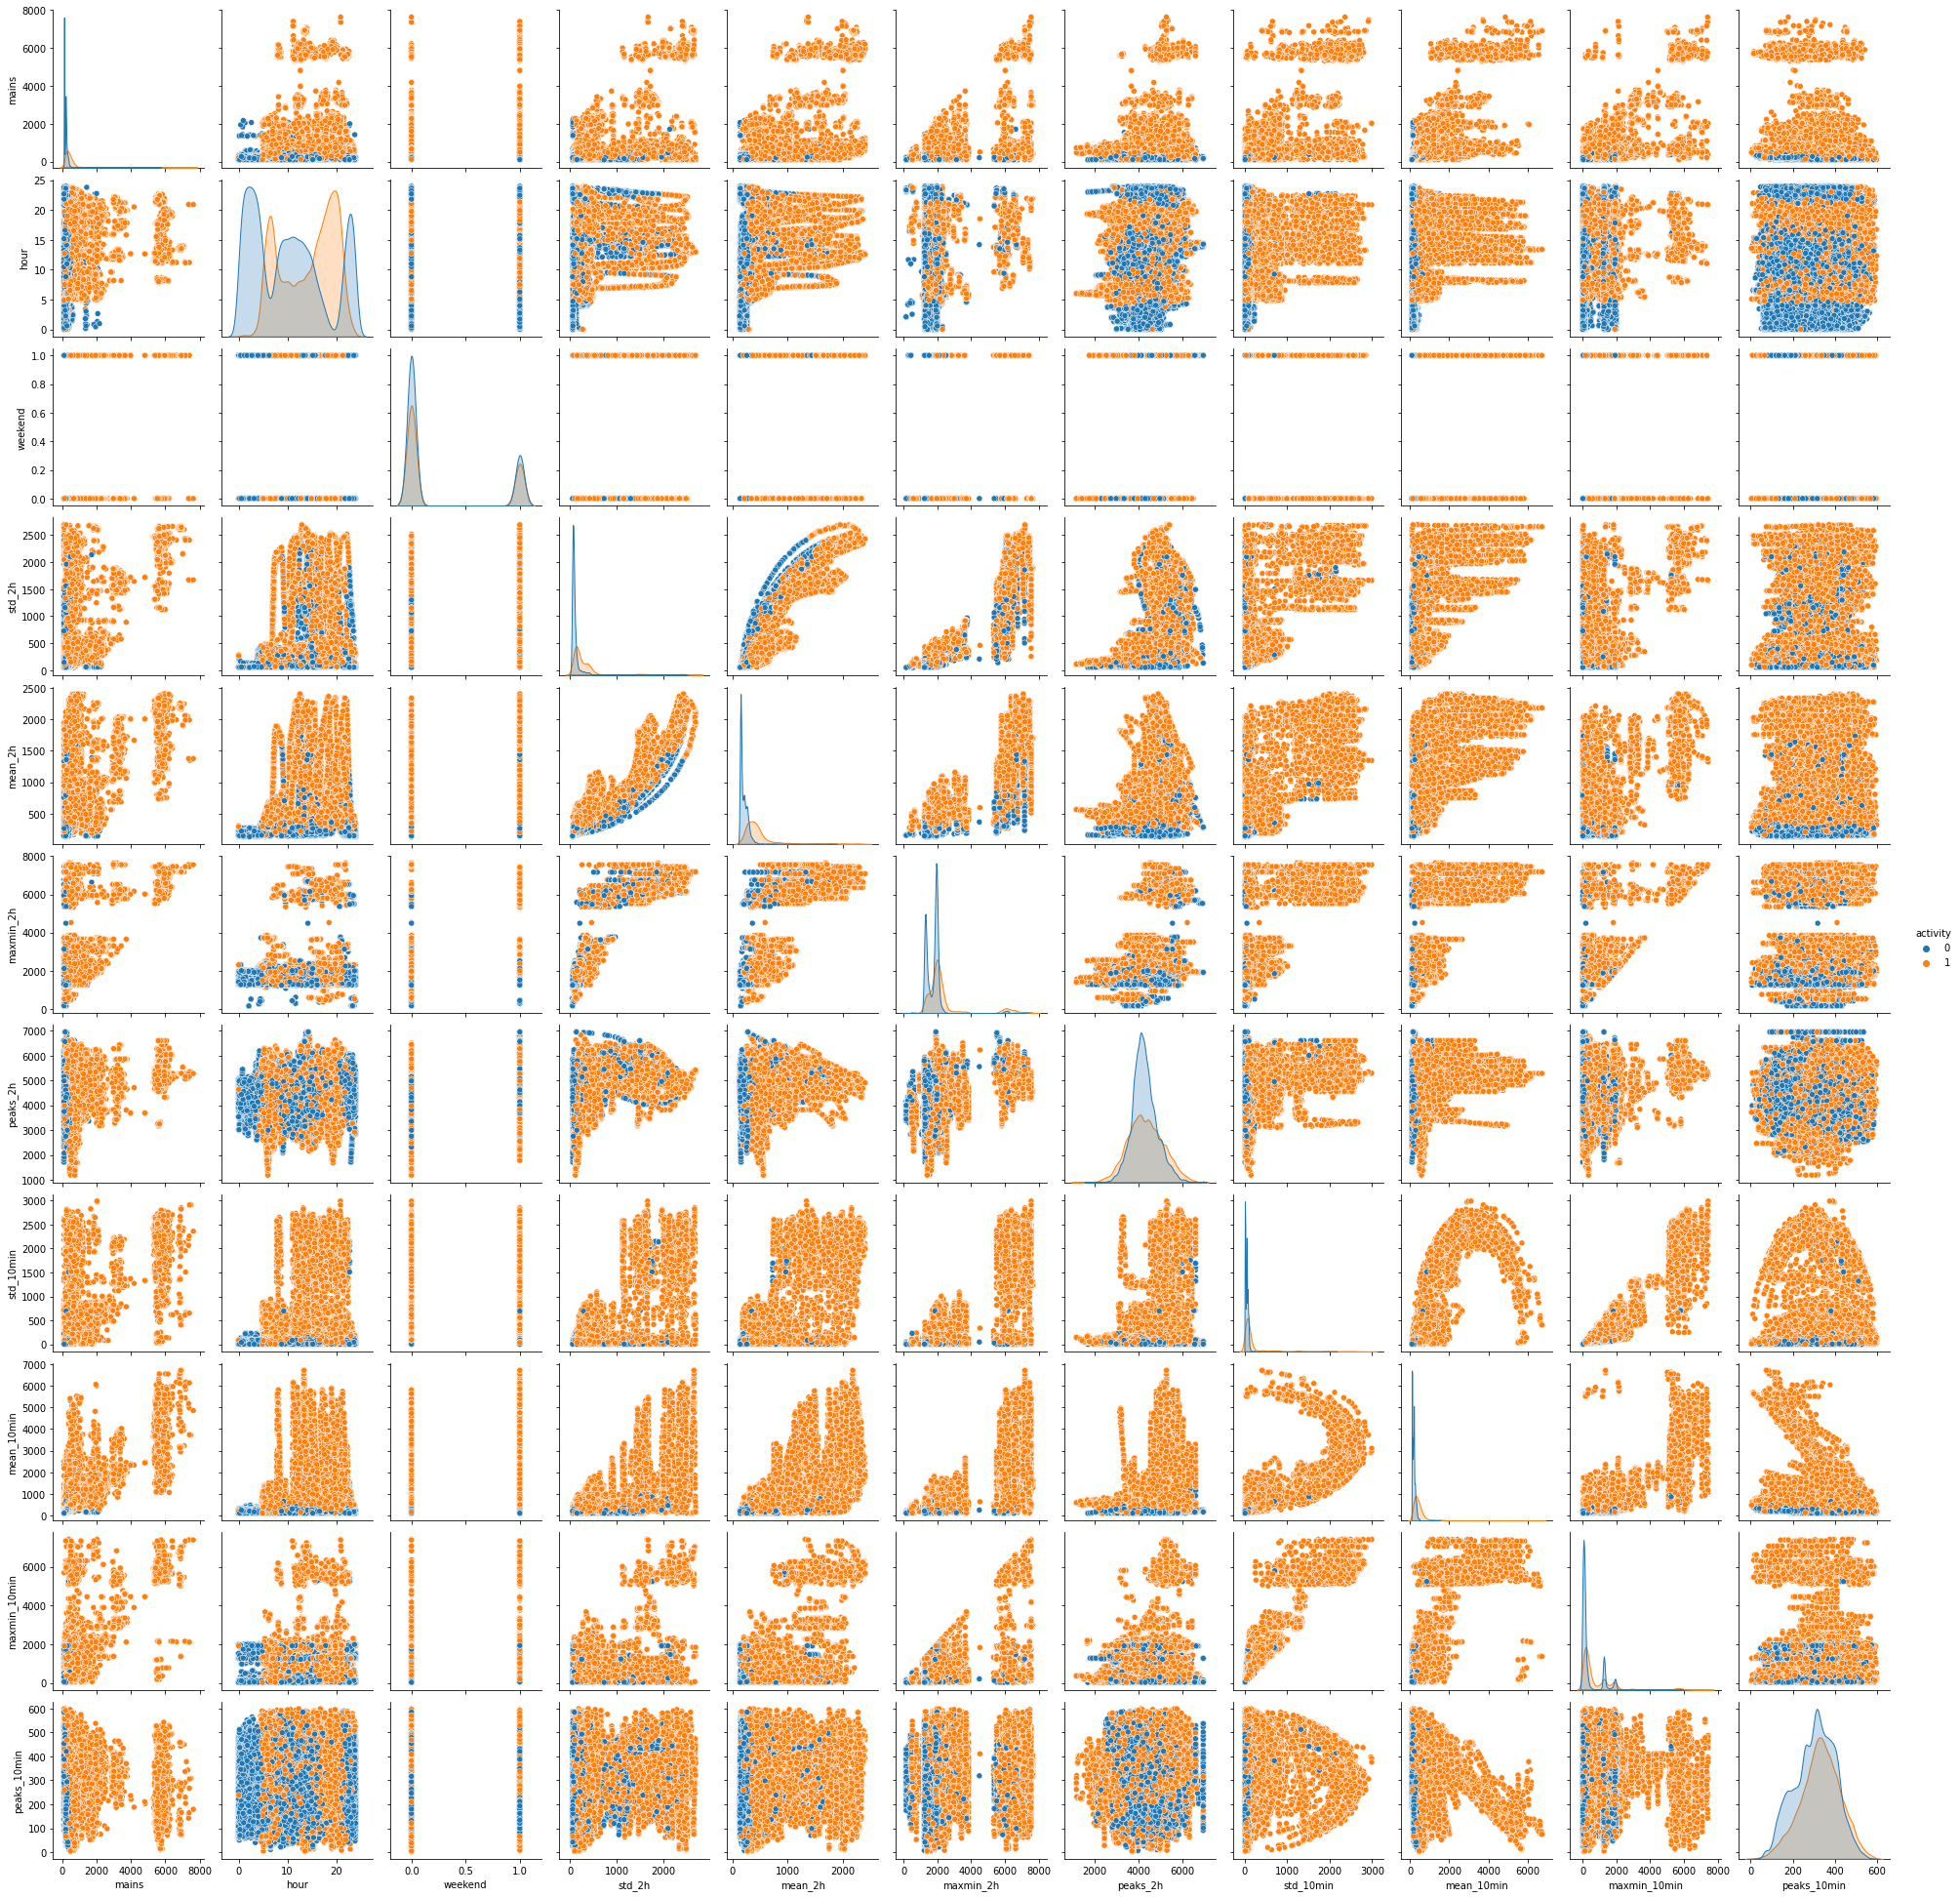

In [11]:
sns.pairplot(house2_power_blk1[features_col + ['activity']].sample(frac=0.05), hue='activity');

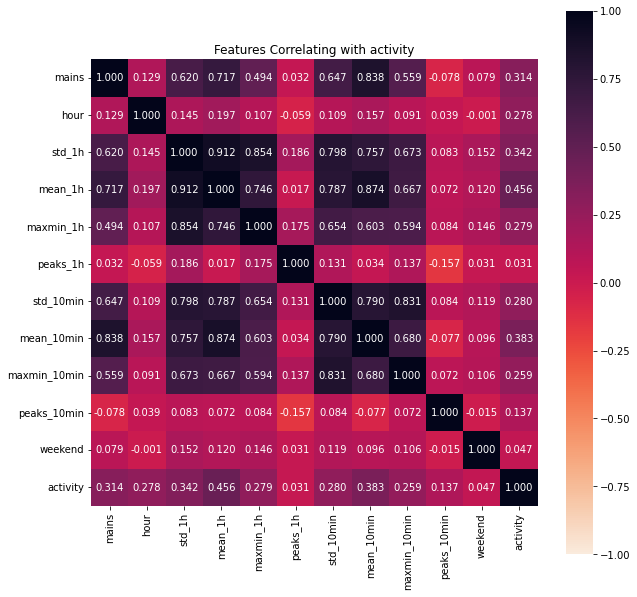

In [4]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(house2_power_blk1[features_col + ['activity']].corr(), vmin=-1, vmax=1, annot=True, fmt='.3f', square=True, cmap=sns.cm.rocket_r)
ax.set_title('Features Correlating with activity');

# 2. Train / test split

In [3]:
best_windows = ['1h', '10min']

house1_power_blk2, cols = mod.generate_features(house2_power_blk1, window=best_windows)
features_col = ['mains', 'hour'] + cols

X_train, X_test, y_train, y_test = mod.split_train_test_scale_df(house2_power_blk1, features_col)

# 3. Algorithmes généraux

tested n_neighbors=5 ...
tested n_neighbors=40 ...
tested n_neighbors=60 ...
tested n_neighbors=90 ...


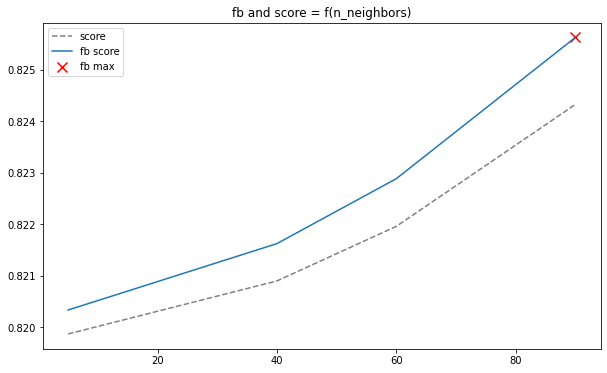

Meilleur fb score=0.83 obtenu pour n_neighbors=90.00
Score f_beta : 82.562%
Score accuracy : 82.432%


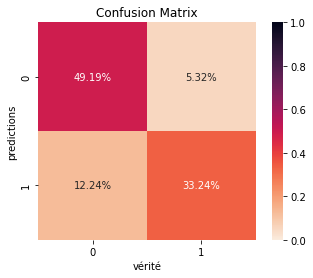

In [5]:
k_range = [5, 40, 60, 90]
mod.plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', k_range);

tested n_estimators=1 ...
tested n_estimators=10 ...
tested n_estimators=20 ...
tested n_estimators=30 ...
tested n_estimators=40 ...
tested n_estimators=60 ...


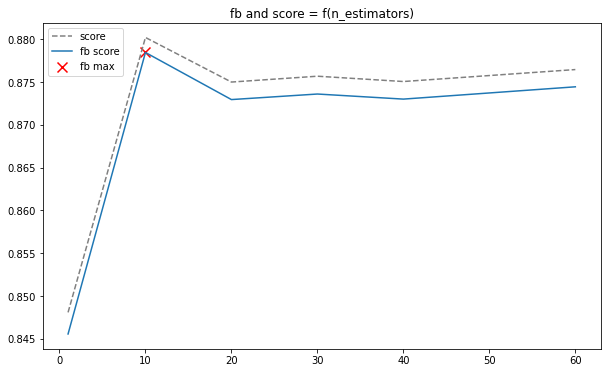

Meilleur fb score=0.88 obtenu pour n_estimators=10.00
Score f_beta : 86.677%
Score accuracy : 86.864%


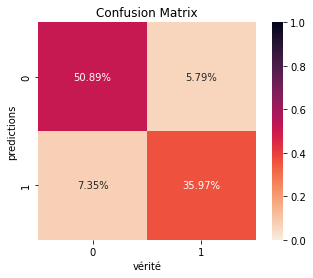

In [5]:
n_range = [1, 10, 20, 30, 40, 60]
mod.plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'max_depth': 10});

tested max_depth=20 ...
tested max_depth=40 ...
tested max_depth=60 ...
tested max_depth=80 ...


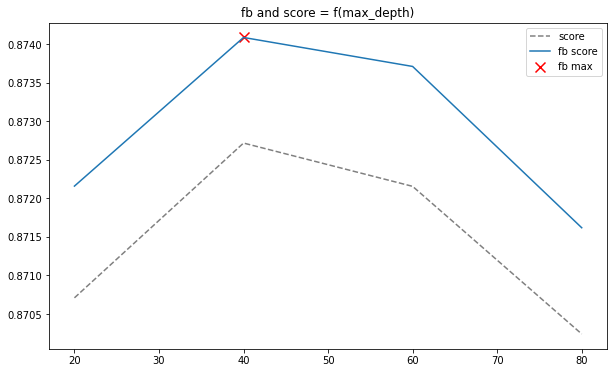

Meilleur fb score=0.87 obtenu pour max_depth=40.00
Score f_beta : 87.679%
Score accuracy : 87.522%


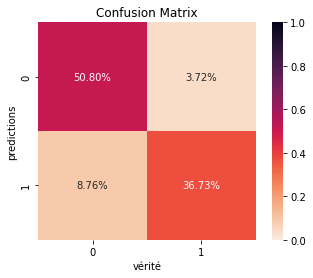

In [4]:
n_range = [20, 40, 60, 80]
mod.plot_scores_param(X_train, X_test, y_train, y_test, HistGradientBoostingClassifier, 'max_depth', n_range, other_params={'max_iter': 300});

### 3.1 Analyse des résultats
Nous allons faire un train/test split en découpant le jeu de données chronologiquement plutôt que par jours aléatoires.

Score f_beta : 77.748%
Score accuracy : 77.903%


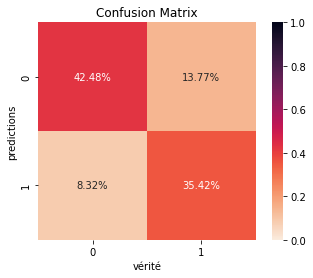

In [4]:
train_dim = int(0.7*len(house2_power_blk1))
# train_dim_h2 = int(0.7*len(house2_power_blk1))
X_train, X_test = house2_power_blk1.iloc[:train_dim]['mains'].values, house2_power_blk1.iloc[train_dim:]['mains'].values
y_train, y_test = house2_power_blk1.iloc[:train_dim]['activity'].values, house2_power_blk1.iloc[train_dim:]['activity'].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)

mod.plot_confusion_matrix(y_test, y_pred);

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


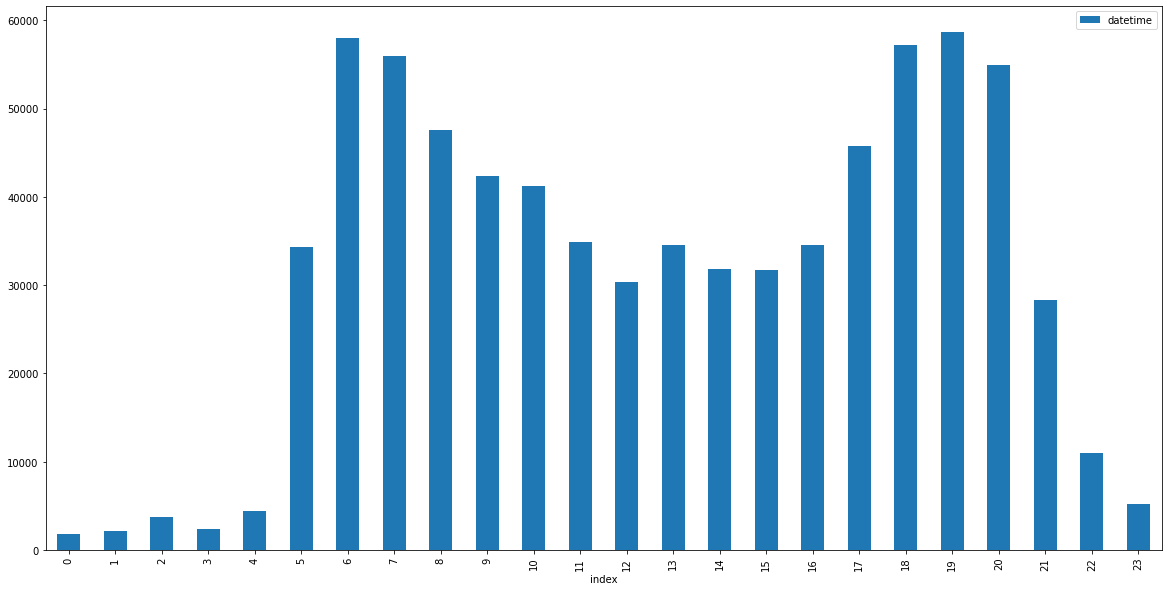

In [5]:
house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res['activity_pred'] = np.nan
house2_power_blk1_res['activity_pred'].iloc[train_dim:] = (y_pred > 0.5).astype(int)
house2_power_blk1_res.iloc[train_dim:].head()

pd.DataFrame(house2_power_blk1_res[house2_power_blk1_res['activity_pred'] > 0].index.hour.value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='datetime', figsize=(20,10), legend='Histogramme activité=f(heure)');

/home/pierre/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


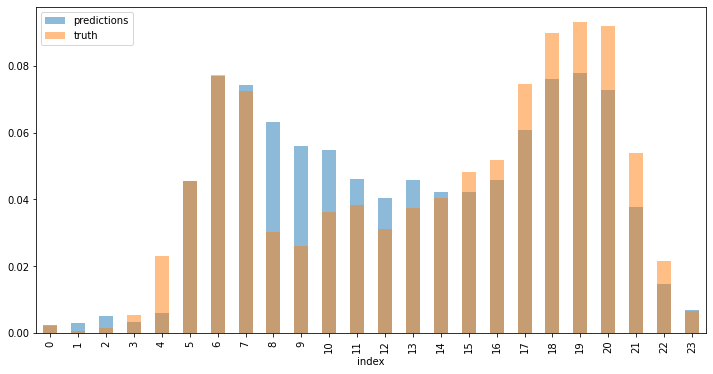

In [5]:
house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res['activity_pred'] = np.nan
house2_power_blk1_res['activity_pred'].iloc[train_dim:] = (y_pred > 0.5).astype(int)
house2_power_blk1_res.iloc[train_dim:].head()

fig, ax = plt.subplots()
mod.plot_activity_hist(house2_power_blk1_res['activity_pred'].iloc[train_dim:], figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(house2_power_blk1['activity'].iloc[train_dim:], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)